In [93]:
import re
import random
import pandas as pd
import hashlib

In [94]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [95]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure Developer Associate,81.535506,16.307101,19.324079,5
CCH Tax Forms Project,151.353955,7.207331,12.541709,21
Azure DevOps Pipelines,187.376616,93.688308,97.914950,2
OAuth 2.0 RFC6749,189.180390,17.198217,24.080183,11
pfSense,242.193764,20.182814,27.766707,12
Active Directory and Azure Files,285.605550,7.719069,16.091400,37
Accounting,293.550257,17.267662,24.574919,17
"The Starless Crown, Rollins",427.070407,15.817422,28.912147,27
Python + Oauth2.0,635.748695,27.641248,41.118164,23
Azure Files Documentation,843.458709,26.358085,49.422503,32


# Histogram

sum of ages: ~54712.16


<Axes: >

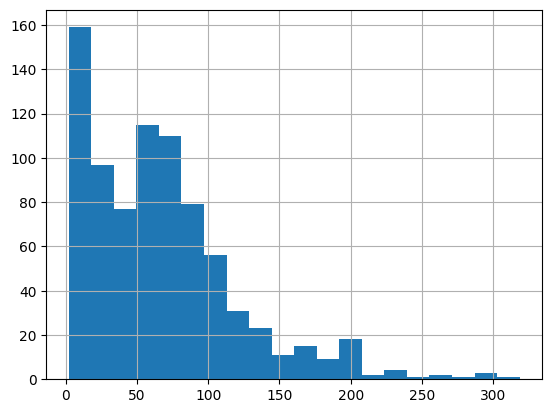

In [96]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~54712.16


<Axes: >

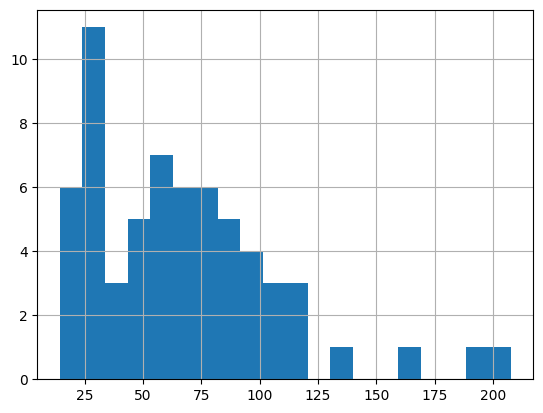

In [97]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='JavaScript Concepts']['age'].hist(bins=20)

# Completely Random Shuffle

In [98]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [99]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [100]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [101]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 814
Total card age: 54712.16


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
73,VMWare,Type 1 Hypervisor\n\nA hypervisor that runs di...,69a3327d36d550a31995e37ddee2031e,-259.610192,-113.492774,259.610192,4199.232629,0.712431,37,0,0
74,VMWare,Type 2 Hypervisor\n\nA hypervisor that runs on...,682c04042ddd52a15c48b98dc0a701f5,-193.469588,-113.492774,259.610192,4199.232629,0.712431,37,3,0
75,VMWare,vSphere\n\nVMware's suite of products for virt...,909faa21893430e575101a484abb85a6,-176.400655,-113.492774,259.610192,4199.232629,0.712431,37,6,0
76,VMWare,High Availability (HA)\n\nA VMware feature tha...,429f5a335074e1ee36aadc9513cb4dee,-153.174661,-113.492774,259.610192,4199.232629,0.712431,37,9,0
77,VMWare,Live Migration\n\nThe process of moving a runn...,beb3774c4f7f72e42fa1fa70a7e26a83,-108.651046,-113.492774,259.610192,4199.232629,0.712431,37,12,0
78,VMWare,Virtual Machine Snapshot\n\nA point-in-time co...,5466cb4e31272a34ffcb34b0b773b2e9,-97.683504,-113.492774,259.610192,4199.232629,0.712431,37,15,0
79,VMWare,Hypervisor\n\nSoftware that allows the creatio...,359bde05d7247fb14a4efb142fed2758,-91.759521,-113.492774,259.610192,4199.232629,0.712431,37,18,0
362,VMWare,ESXi Host Profiles\n\nA feature that allows ad...,c7113982b85ab5645fc1b0e03a6411fc,-90.072521,-113.492774,259.610192,4199.232629,0.712431,37,21,0
637,VMWare,ESXi Free License (VMware ESXi Free)\n\nA free...,0ec21fe996a0720fd0629366a07f4489,-85.049816,-113.492774,259.610192,4199.232629,0.712431,37,24,0
639,VMWare,Fault Tolerance (FT)\n\nA VMware feature that ...,ff8f929f720694365ea8d22041614744,-74.511939,-113.492774,259.610192,4199.232629,0.712431,37,27,0


## Age Max

In [102]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [103]:
# n=4
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [104]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [105]:
existing_cards.head(10)['age'].sum()

np.float64(-1330.3834419147581)

In [106]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
182,FSLogix,A full VHD(x) clone is performed when Cloud Ca...,71af619ba0f37ffd62aa637176cd6ef4,-318.587737,-109.116690,318.587737,1964.100428,0.920318,18,0,0
31,Python,Q:\nHow can you define a custom exception in P...,42a1f83efefd4b56173827e48cae56f3,-299.319776,-63.003696,299.319776,4851.284603,0.915059,77,0,0
14,Vocab,"How to Sell a Haunted House, Hendrix\nDebride ...",1cbf1056a2336f69233d814a8be086c8,-298.830770,-100.350180,298.830770,4917.158835,0.375655,49,0,0
110,Asynchronous Python,"Thread Pool Executor\nA thread pool executor, ...",102c628cf04ad4661a71d437cd297a11,-297.826283,-108.534913,297.826283,3038.977573,0.349113,28,0,0
86,PnP PowerShell,Remove-PnPFile (PnP.PowerShell)\nDeletes a spe...,82aa6d1579ce68a7efaf6bae61eb3a03,-271.429845,-104.820721,271.429845,3983.187386,0.357195,38,0,0
73,VMWare,Type 1 Hypervisor\n\nA hypervisor that runs di...,69a3327d36d550a31995e37ddee2031e,-259.610192,-113.492774,259.610192,4199.232629,0.712431,37,0,0
368,PnP PowerShell,Invoke-RestMethod Parameters\nKey parameters i...,e6a04d0a76f2a4a9cba720d23ffea2c8,-256.586483,-104.820721,271.429845,3983.187386,0.357195,38,1,1
391,Asynchronous Python,asyncio.wait_for()\nRuns a coroutine with a ti...,0ccadcbce46e58eb4de4907f7e86cbf9,-255.109386,-108.534913,297.826283,3038.977573,0.349113,28,1,1
314,Python,Q:\nWhat is the default exit code if a Python ...,b1c1e2234bc8df974f6b207465761b32,-235.883353,-63.003696,299.319776,4851.284603,0.915059,77,1,1
204,Terraform,Built-In Functions:\nDefinition: Terraform pro...,11db06afec8fe1222dc3a034c10f3ebe,-232.419206,-113.269544,232.419206,1132.695438,0.025813,10,0,0


In [107]:
existing_cards['age'].mean()

np.float64(-67.21395910599321)